<a href="https://colab.research.google.com/github/muhiqbalalamin/DeepLearning/blob/main/DeteksiSarkasme_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd
import requests, json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import roc_curve, auc


In [2]:
# Load Dataset
def load_data_from_github():
    url = "https://raw.githubusercontent.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection/master/Sarcasm_Headlines_Dataset.json"
    response = requests.get(url)
    if response.status_code == 200:
        data = [json.loads(line) for line in response.text.splitlines()]
        return pd.DataFrame(data)
    else:
        raise Exception(f"Failed to load data: {response.status_code}")

# Load
print("Loading dataset...")
df = load_data_from_github()
df = df[['headline', 'is_sarcastic']].dropna()
print(f"Loaded {len(df)} samples")
print("Label Distribution:\n", df['is_sarcastic'].value_counts())


Loading dataset...
Loaded 28619 samples
Label Distribution:
 is_sarcastic
0    14985
1    13634
Name: count, dtype: int64


In [3]:
# Tokenizer settings
MAX_VOCAB = 10000
MAX_LEN = 30

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['headline'])
sequences = tokenizer.texts_to_sequences(df['headline'])
padded = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

X = padded
y = df['is_sarcastic'].values

# Split Train & Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [4]:
# Model Builder Function (RNN, LSTM, GRU)
def build_model(model_type='rnn'):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(input_dim=MAX_VOCAB, output_dim=64, input_length=MAX_LEN))

    if model_type == 'rnn':
        model.add(tf.keras.layers.SimpleRNN(64))
    elif model_type == 'lstm':
        model.add(tf.keras.layers.LSTM(64))
    elif model_type == 'gru':
        model.add(tf.keras.layers.GRU(64))

    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model


In [14]:
# Train & Evaluate Functiond

def run_model(model_type):
    print(f"\nTraining {model_type.upper()} model...")
    model = build_model(model_type)

    history = model.fit(X_train, y_train, epochs=10, batch_size=128,
                        validation_split=0.1, verbose=1)

    preds = model.predict(X_test).flatten()
    preds_binary = (preds >= 0.5).astype(int)

    # METRICS
    acc = accuracy_score(y_test, preds_binary)
    prec = precision_score(y_test, preds_binary)
    rec = recall_score(y_test, preds_binary)
    f1 = f1_score(y_test, preds_binary)
    auc_score = roc_auc_score(y_test, preds)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    # PLOT ROC + ACC + LOSS
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"{model_type.upper()} Performance", fontsize=16)

    # ROC Curve
    axs[0, 0].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    axs[0, 0].plot([0, 1], [0, 1], 'k--')
    axs[0, 0].set_title(f'ROC Curve - {model_type.upper()}')
    axs[0, 0].set_xlabel("False Positive Rate")
    axs[0, 0].set_ylabel("True Positive Rate")
    axs[0, 0].legend(loc='lower right')

    # Accuracy
    axs[1, 0].plot(history.history['accuracy'], label='Train Acc', marker='o')
    axs[1, 0].plot(history.history['val_accuracy'], label='Val Acc', marker='s')
    axs[1, 0].set_title(f"{model_type.upper()} Accuracy")
    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].legend()

    # Loss
    axs[1, 1].plot(history.history['loss'], label='Train Loss', marker='o')
    axs[1, 1].plot(history.history['val_loss'], label='Val Loss', marker='s')
    axs[1, 1].set_title(f"{model_type.upper()} Loss")
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].legend()

    axs[0, 1].axis('off')  # Kosongkan 1 plot untuk simetri
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{model_type}_performance.png")
    plt.show()

    return (acc, prec, rec, f1, auc_score)



Training RNN model...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7107 - loss: 0.5349 - val_accuracy: 0.8459 - val_loss: 0.3646
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9180 - loss: 0.2169 - val_accuracy: 0.8332 - val_loss: 0.4163
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9548 - loss: 0.1239 - val_accuracy: 0.8445 - val_loss: 0.4702
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9772 - loss: 0.0679 - val_accuracy: 0.8389 - val_loss: 0.5698
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9842 - loss: 0.0456 - val_accuracy: 0.8332 - val_loss: 0.6335
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9929 - loss: 0.0228 - val_accuracy: 0.8275 - val_loss: 0.7203
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9941 - loss: 0.0188 - val_accuracy: 0.8288 - val_loss: 0.8211
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9961 - loss: 0.0121 - val_accuracy: 0.821

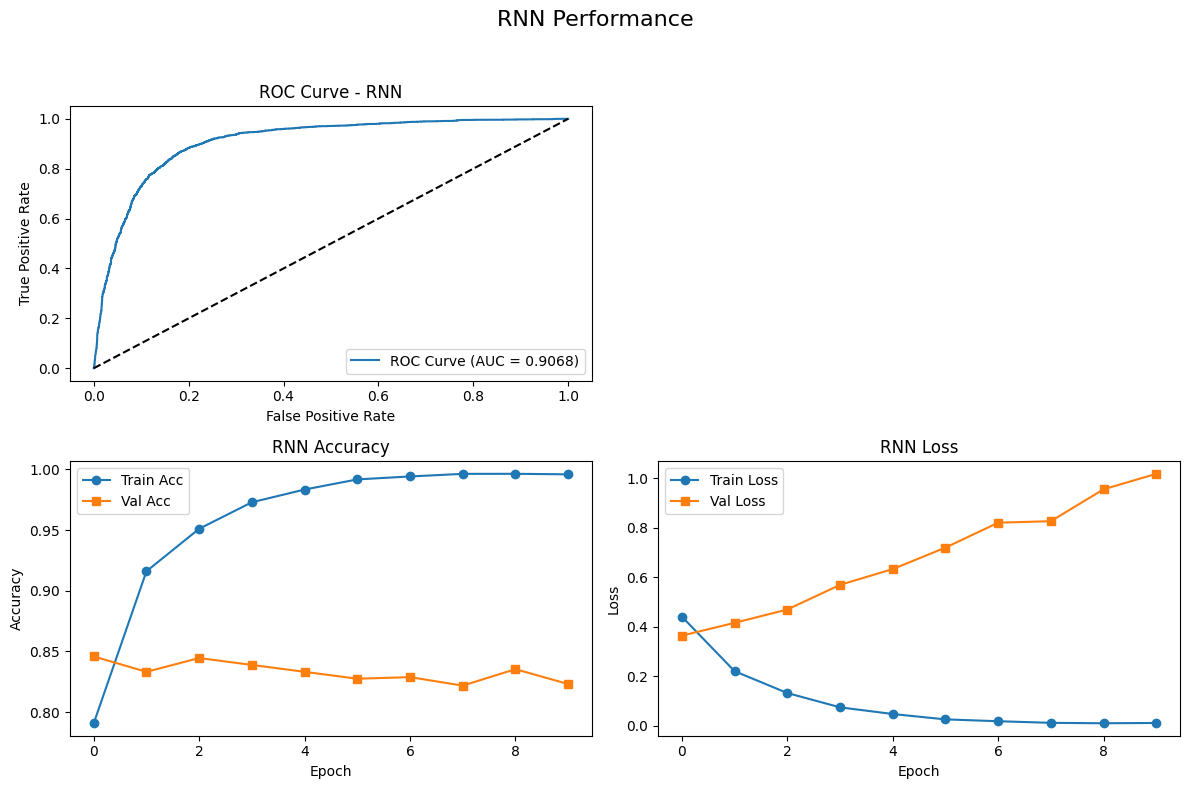

In [15]:
#Run Model
results = {}

# Jalankan masing-masing model
results['rnn'] = run_model('rnn')


Training LSTM model...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


161/161 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.5973 - loss: 0.6240 - val_accuracy: 0.8231 - val_loss: 0.3827
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.8922 - loss: 0.2707 - val_accuracy: 0.8467 - val_loss: 0.3607
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9330 - loss: 0.1734 - val_accuracy: 0.8415 - val_loss: 0.3960
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9523 - loss: 0.1303 - val_accuracy: 0.8384 - val_loss: 0.4401
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.9613 - loss: 0.1111 - val_accuracy: 0.8349 - val_loss: 0.4526
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - accuracy: 0.9696 - loss: 0.0954 - val_accuracy: 0.8323 - val_loss: 0.4681
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9772 - loss: 0.0758 - val_accuracy: 0.8231 - val_loss: 0.5330
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9773 - loss: 0.0713 - val_accuracy:

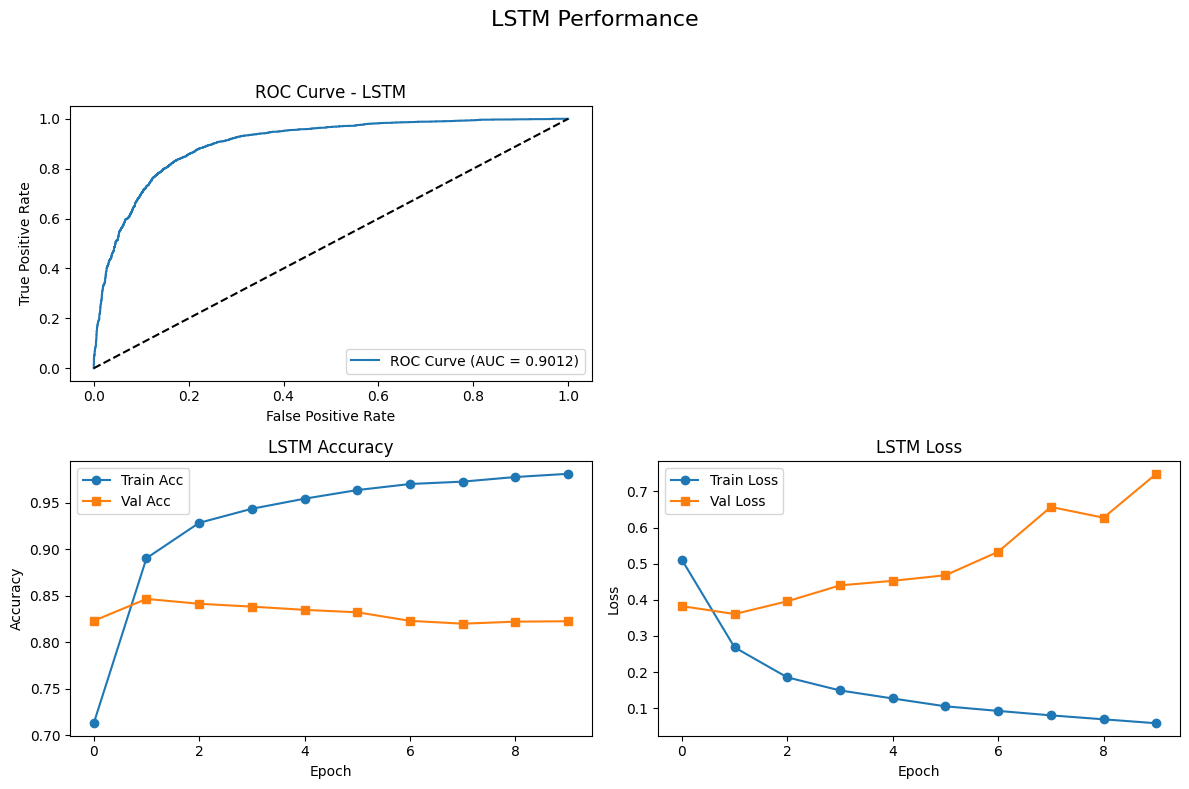

In [16]:
results['lstm'] = run_model('lstm')


Training GRU model...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


161/161 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.5242 - loss: 0.6921 - val_accuracy: 0.5205 - val_loss: 0.6923
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.5447 - loss: 0.6799 - val_accuracy: 0.8096 - val_loss: 0.4263
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.8674 - loss: 0.3180 - val_accuracy: 0.8498 - val_loss: 0.3432
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.9270 - loss: 0.1932 - val_accuracy: 0.8415 - val_loss: 0.3928
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.9503 - loss: 0.1363 - val_accuracy: 0.8424 - val_loss: 0.4235
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.9672 - loss: 0.0985 - val_accuracy: 0.8393 - val_loss: 0.4699
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 20s 71ms/step - accuracy: 0.9787 - loss: 0.0679 - val_accuracy: 0.8358 - val_loss: 0.5954
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - accuracy: 0.9846 - loss: 0.0515 - val_accurac

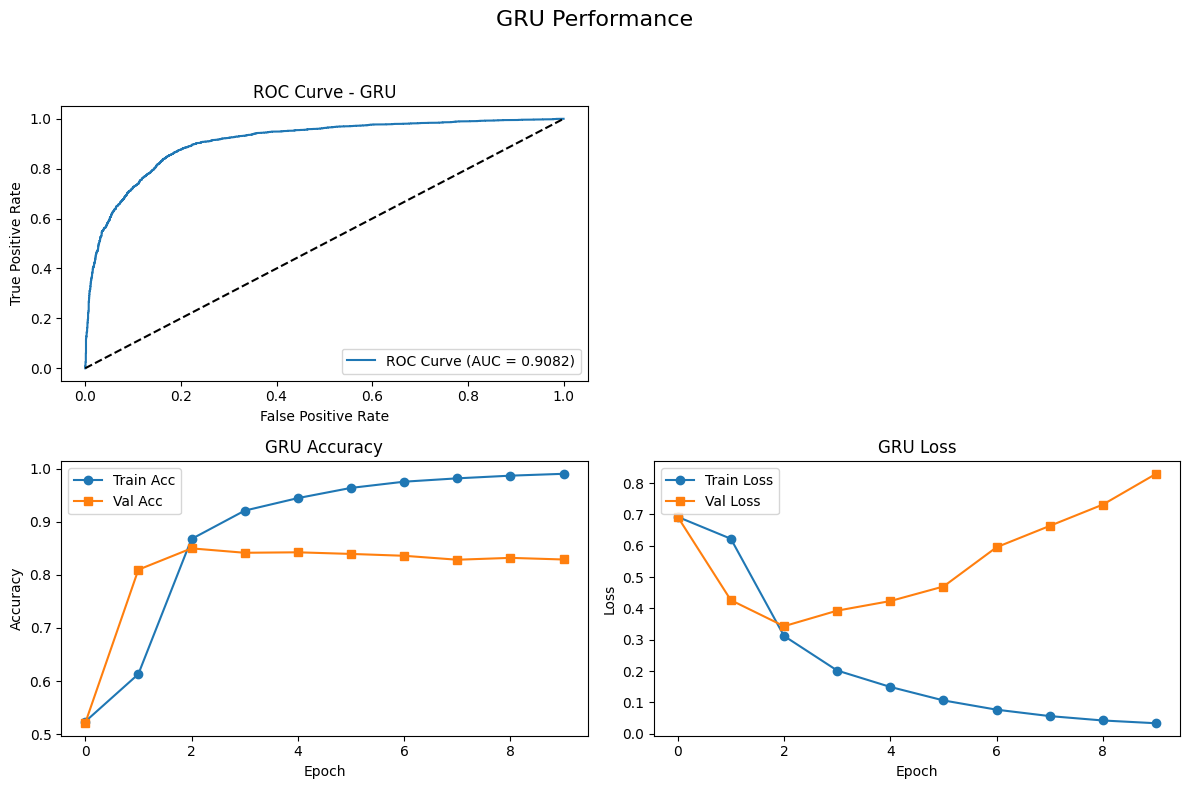

In [17]:
results['gru'] = run_model('gru')

In [18]:
# Comparison Table
print("\n" + "="*50)
print("Model Comparison")
print("="*50)
headers = ["Model", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"]
print(f"{headers[0]:<10} {headers[1]:<10} {headers[2]:<10} {headers[3]:<10} {headers[4]:<10} {headers[5]:<10}")
print("-"*60)

for model_name, metrics in results.items():
    acc, prec, rec, f1, auc = metrics
    print(f"{model_name.upper():<10} {acc:<10.4f} {prec:<10.4f} {rec:<10.4f} {f1:<10.4f} {auc:<10.4f}")



Model Comparison
Model      Accuracy   Precision  Recall     F1 Score   AUC       
------------------------------------------------------------
RNN        0.8401     0.8166     0.8570     0.8363     0.9068    
LSTM       0.8281     0.8215     0.8166     0.8191     0.9012    
GRU        0.8370     0.8217     0.8401     0.8308     0.9082    


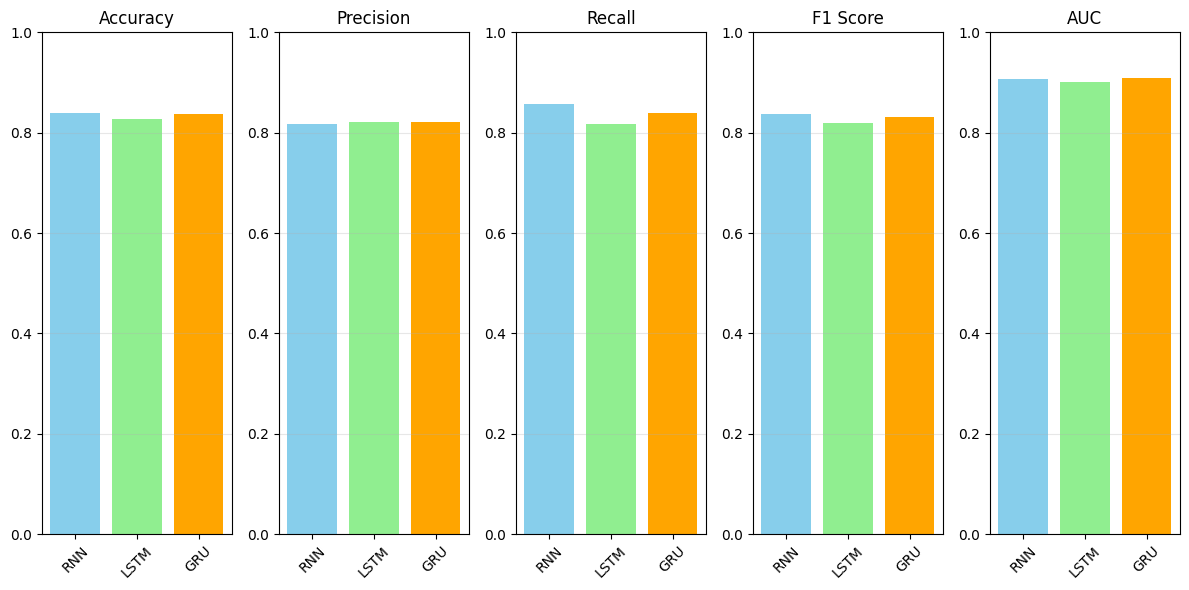

In [19]:
# Visualisasi
plt.figure(figsize=(12, 6))
models = list(results.keys())
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"]

for i, metric in enumerate(metrics):
    plt.subplot(1, 5, i+1)
    values = [results[model][i] for model in models]
    plt.bar([m.upper() for m in models], values, color=['skyblue', 'lightgreen', 'orange'])
    plt.title(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("model_comparison_tf.png")
plt.show()
